In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import numpy as np
import matplotlib.pyplot as plt
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.AddChanneld(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

C:\ProgramData\Anaconda3\envs\CandidateNet\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
slice_max

423

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

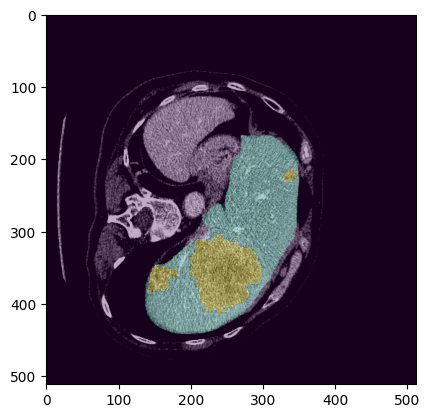

In [10]:
visualize_data(inputs, labels)

In [11]:
class RegularNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 3, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x):
        return self.net(x)
        
        

In [12]:
class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [13]:
class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None, n_local=64, n_region=64):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, qkv_bias)
        
        self.n_local_tokens = n_local
        self.n_region_tokens = n_region
        '''
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None
        '''
        if window_size:
            self.window_size = window_size
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
            # cls to token & token 2 cls & cls to cls

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)

            # trunc_normal_(self.relative_position_bias_table, std=.0)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias_local=None, rel_pos_bias_region=None):
        B, N, C = x.shape
        '''
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        '''
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias_local is not None:
            nlt = self.n_local_tokens
            attn[:,:,0:nlt,0:nlt] = attn[:,:,0:nlt,0:nlt] + rel_pos_bias_local
        if rel_pos_bias_region is not None:
            nlt = self.n_local_tokens
            nrt = self.n_region_tokens
            attn[:,:,nlt:nlt+nrt,nlt:nlt+nrt] = attn[:,:,nlt:nlt+nrt,nlt:nlt+nrt] + rel_pos_bias_region
        

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [14]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None, n_local=64, n_region=64):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim, n_local=n_local, 
                n_region=n_region)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias_local=None, rel_pos_bias_region=None):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias_local=rel_pos_bias_local, 
                                                            rel_pos_bias_region=rel_pos_bias_region))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias_local=rel_pos_bias_local, 
                                                            rel_pos_bias_region=rel_pos_bias_region))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [15]:
class RelativePositionBias(nn.Module):

    def __init__(self, window_size, num_heads):
        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1)
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # cls to token & token 2 cls & cls to cls

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        # trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self):
        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        return relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

In [25]:
class LRGNet(nn.Module):
    def __init__(self, window_size=8):
        super().__init__()
        
        self.xdim = 192
        self.dim = 200
        self.local_patch_size = 1
        self.region_patch_size = 64
        self.global_patch_size = 512
        self.depth = 8
        self.num_heads = 16
        self.window_size = window_size
        self.out_dim = 3
        self.mlp_ratio = 4.0
        
        self.n_local_tokens = window_size * window_size
        self.region_window_size = (self.global_patch_size // self.region_patch_size)
        self.n_region_tokens = self.region_window_size ** 2
        
        
        
        self.local_pe = nn.Sequential(nn.Conv2d(1, self.dim, kernel_size=self.local_patch_size, stride=self.local_patch_size, padding=0),
                                      nn.BatchNorm2d(self.dim))
        self.region_pe = nn.Sequential(nn.Conv2d(1, self.dim, kernel_size=self.region_patch_size, stride=self.region_patch_size, padding=0),
                          nn.BatchNorm2d(self.dim))
        
        self.rel_pos_bias_local = RelativePositionBias(window_size=(window_size, window_size), num_heads=self.num_heads)
        self.pos_embed = nn.Linear(2, 8)
        
        reg_pos_reg_t = torch.stack(torch.meshgrid([torch.arange(self.region_window_size), 
                                                    torch.arange(self.region_window_size)]), axis=0)
        reg_pos_reg_t = reg_pos_reg_t.view(2,-1)
        self.reg_pos_reg_t = reg_pos_reg_t.permute(1, 0).to(device)
        self.reg_pos_glob_t = torch.Tensor([[-1, -1]]).to(device)

        b_dim = self.dim + 8
        
        self.blocks = nn.ModuleList([
            Block(
                dim=b_dim, num_heads=self.num_heads, mlp_ratio=self.mlp_ratio, n_local=self.n_local_tokens,
                n_region=self.n_region_tokens)
            for i in range(self.depth)])
        
        self.out = nn.Linear(self.dim, self.out_dim)
        
    def forward(self, x, indx):
        B, C, H, W = x.shape
        region_tokens = self.region_pe(x)
        global_token = nn.functional.avg_pool2d(region_tokens, 
                                                kernel_size=self.global_patch_size // self.region_patch_size)
        x_pos = indx[0][0]
        y_pos = indx[0][1]
        local_data = x[:,:,x_pos:x_pos+self.window_size,y_pos:y_pos+self.window_size]
        local_tokens = self.local_pe(local_data)
        
        rpb_l = self.rel_pos_bias_local()
        reg_pos_local_t = torch.Tensor([x_pos // self.region_patch_size, 
                                        y_pos // self.region_patch_size]).repeat(self.n_local_tokens).view(-1,2).to(device)
        reg_pos_t = torch.cat([reg_pos_local_t, self.reg_pos_reg_t, self.reg_pos_glob_t], dim=0)
        reg_pos = self.pos_embed(reg_pos_t)
        
        
        region_tokens = region_tokens.flatten(2).permute(0, 2, 1)
        global_token = global_token.flatten(2).permute(0, 2, 1)
        local_tokens = local_tokens.flatten(2).permute(0, 2, 1)
        
        all_tokens = torch.cat([local_tokens, region_tokens, global_token], dim=1)
        
        all_tokens = torch.cat([all_tokens, reg_pos.unsqueeze(0)], dim=2)
        
        for i, blk in enumerate(self.blocks):
            all_tokens = blk(all_tokens, rpb_l)

        local_tokens = all_tokens[:,0:self.n_local_tokens,0:self.dim]
        y = self.out(local_tokens)
        y = y.view(B, self.window_size, self.window_size, self.out_dim)
        y = y.permute(0,3,1,2)
        return y
        
            
            
        

In [29]:
window_size = 16
model = LRGNet(window_size=window_size)
model.to(device)
print(count_parameters(model))

5006587


Epoch: 49, Dice score: 0.4641834795475006, loss: 0.7027543783187866
Epoch: 99, Dice score: 0.4191669821739197, loss: 0.6895471811294556
Epoch: 149, Dice score: 0.4739759862422943, loss: 0.6689799427986145
Epoch: 199, Dice score: 0.43551620841026306, loss: 0.6677327156066895
Epoch: 249, Dice score: 0.4487666189670563, loss: 0.6730620265007019
Epoch: 299, Dice score: 0.4258449077606201, loss: 0.665191650390625
Epoch: 349, Dice score: 0.4401799738407135, loss: 0.6680545806884766
Epoch: 399, Dice score: 0.45720189809799194, loss: 0.6617037057876587
Epoch: 449, Dice score: 0.46395742893218994, loss: 1.4985753297805786
Epoch: 499, Dice score: 0.47056666016578674, loss: 0.6652132272720337


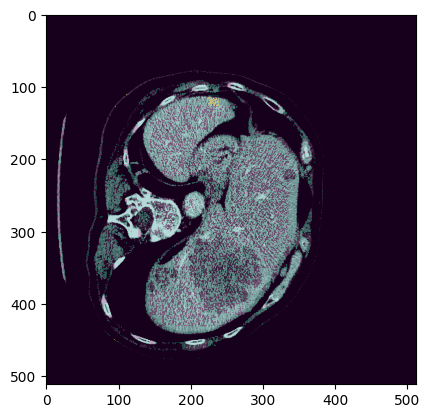

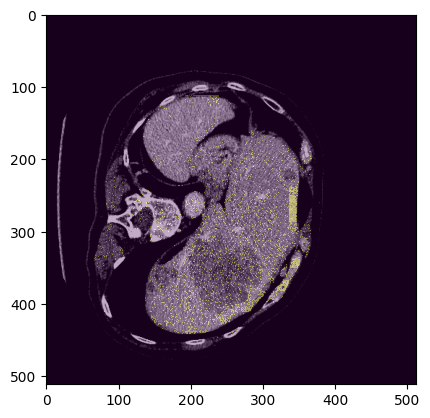

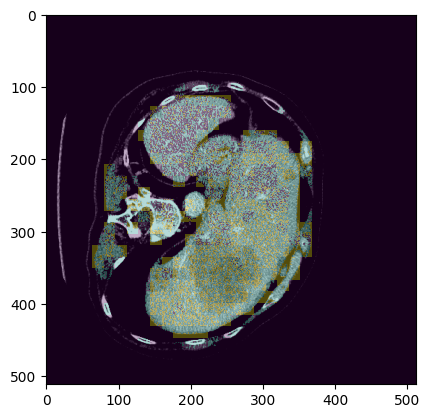

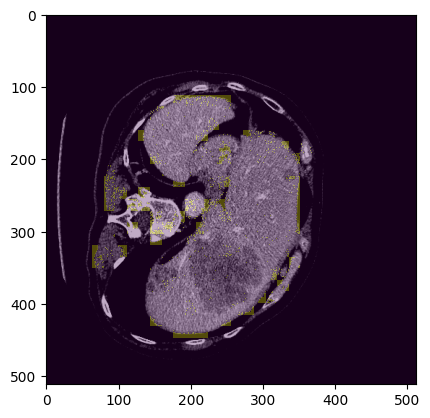

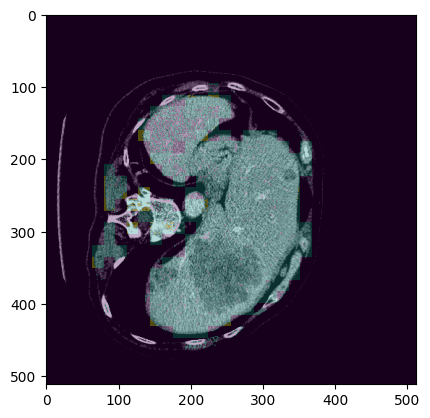

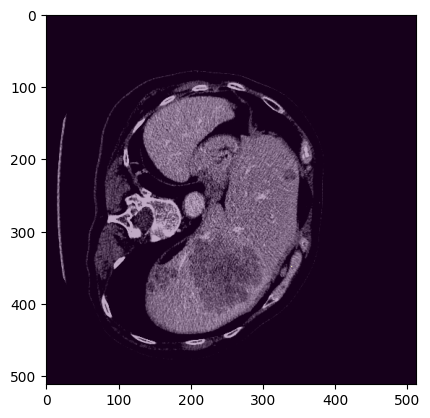

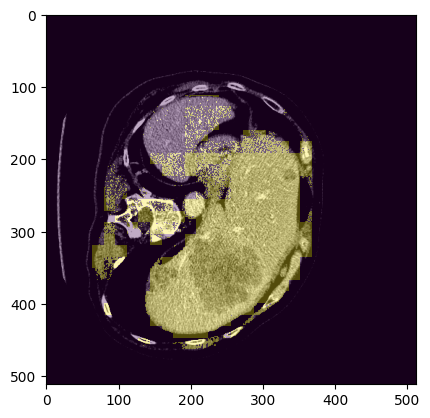

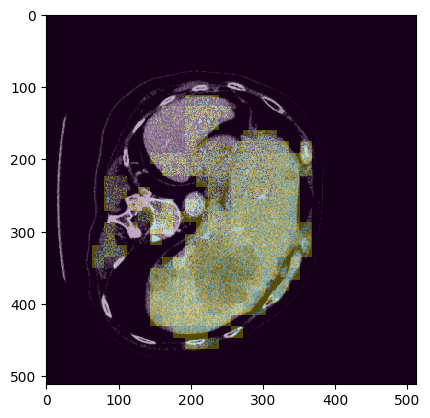

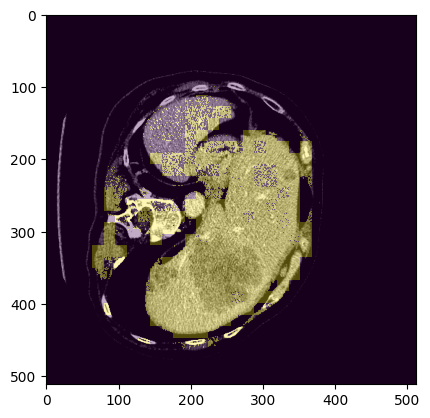

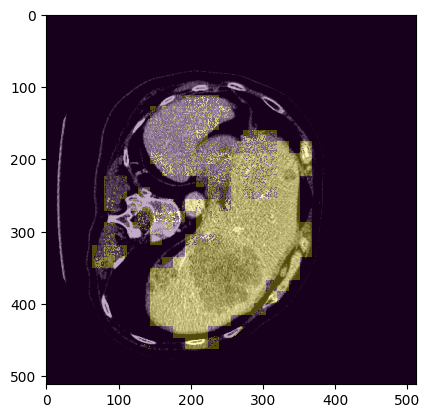

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 500
total_prints = 10
print_every_n_epochs = epochs // total_prints


for e in range(epochs):
    indx = torch.randint(512-window_size, (1,2))
    x_pos = indx[0][0]
    y_pos = indx[0][1]
    outputs = model(inputs, indx)
    local_labels = labels[:,:,x_pos:x_pos+window_size,y_pos:y_pos+window_size] 
    loss = criterion(outputs, local_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if ((e + 1) % print_every_n_epochs) == 0:
        
        all_outputs = torch.zeros(1, 3, 512, 512, device=device)
        all_x_pos = torch.arange(0, 512, window_size)
        all_y_pos = torch.arange(0, 512, window_size)
        for x in all_x_pos:
            for y in all_y_pos:
                with torch.no_grad():
                    indx = torch.Tensor([[x, y]]).int()
                    outputs = model(inputs, indx)
                    all_outputs[:,:,x:x+window_size,y:y+window_size] = outputs

        labels_convert = [post_label(labels[0])]
        output_convert = [post_pred(all_outputs[0])]
        dice_metric(y_pred=output_convert, y=labels_convert)
        dice_scores, dice_not_nans = dice_metric.aggregate()            
        pred = torch.argmax(all_outputs, dim=1)
        visualize_data(inputs, pred)
        print("Epoch: {}, Dice score: {}, loss: {}".format(e, dice_scores.item(), loss.item()))